In [1]:
#import libraries
#from __future__ import division, print_function, absolute_import

from tmm.tmm_core import (inc_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)
import numpy as np
#from numpy import pi, linspace, inf, array, loadtxt
import math
import cmath
import matplotlib.pyplot as plt

#import pandas as pd

# Import the function 'join' from the module 'os.path'
# This function automatically takes care of the slashes that need to be added when combining two paths.
from os.path import join

# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = np.pi/180

In [2]:
#path and definitions
dirpath = r'/Users/twenzel/ownCloudP/DreamHost/#Irridescent mineral project/Python simulation TTM/results/'

#define wavelength and angular intervals
lamb= np.linspace(400,800,num=100) #40
angles= np.linspace(-17,17,35) #19
N = 1

[400, 800, 0, 0.35]

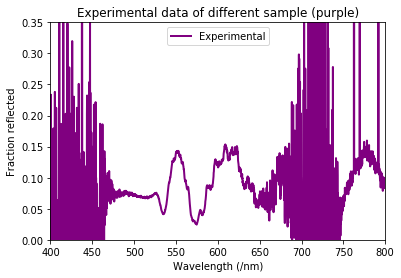

In [3]:
#Load experimental spectra so they can be plotted together with simulation
data = np.loadtxt('Spec5.csv',delimiter=';',skiprows=1)
#data.head() #display first five lines
expx = data[:,0] #accumulative depth value of layer
expy = data[:,1] #normalised gray value of layer

#plot experiments
plt.plot(expx,expy,'purple',lw=2,label="Experimental")
plt.legend()
plt.xlabel('Wavelength (/nm)')
plt.ylabel('Fraction reflected')
plt.title('Experimental data of different sample (purple)')
plt.axis([400, 800, 0, 0.35])

In [4]:
#generate list of refractive indicees
def generateNlist(gray_list,lamb):
    n_list = np.zeros((lamb.size, gray_list.size), dtype=np.complex_)
    n1 = np.zeros((lamb.size, gray_list.size), dtype=np.complex_)
    
    #for k in 1/lamb:
    air = 1.00029
    AS = 0.0162 #Sellmeier parameter for dispersion equation
    BS = 0.2658 #Sellmeier parameter for dispersion equation

    for i, wl in enumerate(lamb):
        k = 1/wl
        #n=sqrt( (1/( (-AS*(kˆ2))+BS ) ) +1)
        n1[i,:] = math.sqrt( (1/( (-AS*(k**2))+BS ) ) +1)
        
                    #.T transposes the array
        #gray_list_trans=np.zeros((1, gray_list.size))
        #gray_list_trans[:, 0:] = gray_list[0:]
        
        for l in range(len(gray_list)): ######################## STILL NEEDS FIXING ##########################
            # real an imaginary part
            #n_list[i,l].real= air +((n1[i,l].real - air) * (gray_list_trans[0,l]))
            #n_list[i,l].imag= n1[i,l].imag * gray_list_trans[0,l]
            n_list[i,l] = complex(air +((n1[i,l].real - air) * (gray_list[0,l])), n1[i,l].imag * gray_list[0,l])

#     plt.figure(3)
#     plt.plot(lamb, n1.imag, marker='o', ms = 10, alpha=1, color='b', label='Rock layers')
#     plt.plot(lamb, n1.real, marker='d', ms = 10, alpha=1, color='g', label='Rock layers')
#     plt.xlabel('Wavelength (/nm)')
#     plt.ylabel('Refractive index')
#     plt.title('Dispersion relations, imaginary part and real part. Blue = Rock layers')
    plt.imshow(n1.real)
        
    #adds bottom infinite layer at the end of the n list (same as last n calculated)
    #n_last = []
    n_lists = np.column_stack((n_list, n_list[:, -1]))
    #n_lists = np.append(n_list, n_list[:, -1], axis=1) #alternative?
    #adds air layer at the top of the n list
    n_list = np.insert(n_lists, 0, air, axis=1)

    Filename2 = "n_listreal.txt"
    Filename3 = "n_listimaginary.txt"
    filepathRNA = join(dirpath, Filename2)
    filepathRNA = join(dirpath, Filename3)
    np.savetxt(filepathRNA,  n_list.real, delimiter=" ")
    np.savetxt(filepathRNA, n_list.imag, delimiter=" ")  
    
    return n_list

In [5]:
def reflectionsim(lamb, angles, n_list, d_list, c_list, N):

    RNA = np.zeros((lamb.size,angles.size))
    
    for i in range(lamb.size):
        for j in range(angles.size):
            RNA[i,j] = inc_tmm('s',n_list[i,:], d_list, c_list, angles[j]*degree, lamb[i])['R']
            RNA[i,j] += inc_tmm('p',n_list[i,:], d_list, c_list, angles[j]*degree, lamb[i])['R']
    #both polarisations, averaged 
    RNA = RNA/2
    RNAmean = np.mean(RNA, axis=1)
    return RNAmean

In [6]:
# Read in microscope image
def ExtractProfiles(inname, outname):
    # This program is (arbitrarily) set to work with images in the .tif format.

    I = plt.imread(inname+'.tif',format='tif') # import image
    #plt.imshow(I)
    Image = I[:,:,0] #get rid of other image channels that are the same

    # Calculate index changes
    # imshow(I)
    # size(I)
    BulkNr = Image.shape[1]

    ProfileAll = np.sum(Image, axis=1)/BulkNr/255 #devide by index number og 8bit images (255)
    ProfileAll.shape

    #now only consider a third of the image for averaging each time
    ThirdPixels = int(np.floor(BulkNr/3))
    ProfileThird1 = np.sum(Image[:,1:ThirdPixels],axis=1)/ThirdPixels/255
    ProfileThird2 = np.sum(Image[:,ThirdPixels+1:2*ThirdPixels],axis=1)/ThirdPixels/255
    ProfileThird3 = np.sum(Image[:,(2*ThirdPixels)+1:3*ThirdPixels],axis=1)/ThirdPixels/255
    
    X = np.arange(len(ProfileThird3))
    plt.plot(X,ProfileAll,X,ProfileThird1,X,ProfileThird2,X,ProfileThird3)
    plt.show()
    
    #save the profiles
    np.savetxt(join(dirpath, outname+'_1.csv'), ProfileThird1, delimiter=",")
    np.savetxt(join(dirpath, outname+'_2.csv'), ProfileThird2, delimiter=",")
    np.savetxt(join(dirpath, outname+'_3.csv'), ProfileThird3, delimiter=",")
    
    return ProfileThird1, ProfileThird2, ProfileThird3

In [7]:
def Aggregate(profile,pxlscale,outname):
    #profile,_,_=ExtractProfiles(ImName, SaveName)
    #pxlscale = 200/120 #200nm is 120 pixel
    #outname = 'Gracscale_profile_aggregated_scaled' # CHOOSE NAME TO SAVE

    profile=np.around(profile,2) #round floating numbers of profile to 2 decimal places

    #loop to remove equal value layers 
    #initial attempt #idx = np.array(np.ediff1d(profile,to_begin=0),dtype=bool) #set true where the previous element is equal
    profile_aggregated = np.array([]) #initialise new profile array
    idx_aggregated = np.array([]) #initialise new index array
    for k,item in enumerate(profile):
        if k==0: #first item cannot be compared to previous
            profile_aggregated = item
            idx_aggregated = 1
            #elif k==(len(profile)-1): #last item
        elif item == profile[k-1]: #increase llayer-pixel-thicknes number if value is equal
            idx_aggregated[-1] += 1
        else: #if layer value differs, record along with layer-pixel-thicknes value 1
            profile_aggregated = np.append(profile_aggregated, item)
            idx_aggregated = np.append(idx_aggregated, 1)

    #plot the plain aggregated array
    X = np.arange(len(profile_aggregated))
    plt.plot(X,profile_aggregated)
    plt.show()

    #change layer-thickness from pixel values to nanometer and add first (air) and last (solid)
    idx_aggregated_scaled = idx_aggregated * pxlscale
    print(idx_aggregated_scaled.shape)
    idx_aggregated_scaled = np.append(idx_aggregated_scaled, np.inf)
    idx_aggregated_scaled = np.insert(idx_aggregated_scaled, 0, np.inf)
    profile_aggregated = np.append(profile_aggregated, 1)
    profile_aggregated = np.insert(profile_aggregated, 0, 0)

    Aggregated_layers_profile = np.array([idx_aggregated_scaled, profile_aggregated]) #combine into one 2D array
    print(Aggregated_layers_profile.shape)
    
    #save the profile
    np.savetxt(join(dirpath, outname+'.csv'), Aggregated_layers_profile, delimiter=",")
    
    return Aggregated_layers_profile

In [8]:
#ALTERNATIVE# Load profile from .csv file

# #Read the layers' positions and gray values from structure profile.
# ftemp = np.loadtxt("ProfileTotalLong.csv",delimiter=',',skiprows=1) #or read incremental file name ("Plot Values "+str(n+20-N)+".xls")
# t_list = ftemp[:,0] #thickness of each layer
# gray_list = ftemp[:,1]

# # plt.figure(3)
# # plt.plot(t_list, gray_list, marker='o', ms = 10, alpha=1, color='b', label='Rock layers')
# # plt.xlabel('Wavelength (/nm)')
# # plt.ylabel('Refractive index')
# # plt.title('tenp plot')

# #Adds top and bottom inf layers to d list
# t_lists = np.append(t_list, np.inf)
# d_list = np.insert(t_lists, 0, np.inf)
# #correction = 0.05 #0.055
# #d_list = d_lists*(1-correction)

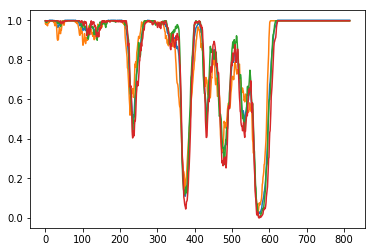

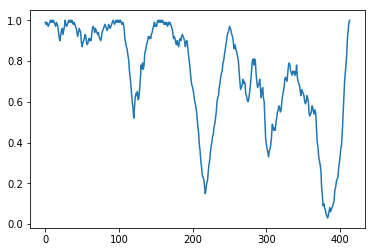

(414,)
(2, 416)


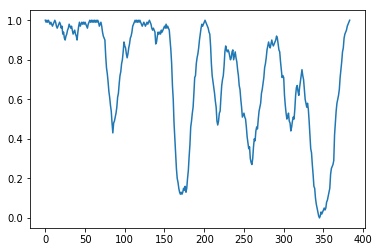

(384,)
(2, 386)


In [11]:
#call profile extraction function
ImName = 'Picture1_bw' # INPUT NAME OF TEM-IMAGE
SaveName = 'Gracscale_profile' # CHOOSE NAME TO SAVE
p1,p2,p3 = ExtractProfiles(ImName, SaveName+'_raw')

#call profile aggregation and scaling function
PxlScale = 200/120 #200nm is 120 pixel
PGray1 = Aggregate(p1,PxlScale,SaveName+'_aggreg_scaled_p1')
PGray2 = Aggregate(p2,PxlScale,SaveName+'_aggreg_scaled_p2')
#PGray3 = Aggregate(p3,PxlScale,SaveName+'_aggreg_scaled_p3')


In [ ]:
#Run the simulation

#initialise array
RNAmeans = np.zeros((N, lamb.size))

#for n in range(N):
#    print(n)
n=1

#call refractive index generation function
n_list = generateNlist(gray_list,lamb)

In [ ]:
# C_list: same lenght as t_list. First and last value must be 'i'.
#c = np.zeros_like(t_list)
a = ['c']*len(t_list)
b = np.append(a, 'i')
c_list = np.insert(b, 0, 'i')

RNAmeans[n,:] = reflectionsim(lamb, angles, n_list, d_list, c_list, N)

plt.figure(0)
plt.plot(lamb,RNAmeans[n,:],'--')


#plot the results vs experiments
plt.plot(lamb,RNAmeans.mean(0),'blue',lw=2,label="Average")
plt.plot(expx,expy,'purple',lw=2,label="Experimental")
plt.legend()
plt.xlabel('Wavelength (/nm)')
plt.ylabel('Fraction reflected')
plt.title('Simulated reflection of unpolarized light at 0$^\circ$ incidence (purple), '
            'Experimental data of different sample (purple)')
plt.axis([400, 800, 0, 0.35])

In [ ]:
#save simulation data in a text file made out of columns delimited by a space
Filename1 = "RNAmeans.txt"
filepathRNA = join(dirpath, Filename1)
np.savetxt(filepathRNA, RNAmeans, delimiter=" ")

In [ ]:
#for error checking, plot the refractive index profile
position = np.genfromtxt("ProfileTotal.xls",delimiter="\t")
position = position[:,0]
pos = np.delete(position, 0)
poss = np.delete(pos,1)
#n_list_imaginary = n_list[N/2, 1:-1].imag

k = 0.002 #500nm
plt.figure(1)
#plt.plot(poss, n_list[1:-1].imag, 'red')
plt.plot(poss, n_list[N/2, 1:-1], 'red')

plt.xlabel('Distance (/nm)')
plt.ylabel('Im{refractive index}')
#plt.title('Simulated reflection of unpolarized light at 0$^\circ$ incidence (blue), '
            #'Experimental data (purple)')
#plt.axis([0, 2000, -0.10, 0.10])
plt.axis([0, 2000, 1.0, 2.0])
plt.show()